In [260]:
import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torch
import glob
import random
from torch.utils.data import Dataset
from PIL import Image
import sys
import torch
from torchvision.utils import save_image, make_grid
from torch.utils.tensorboard import SummaryWriter
import warnings
from torch.nn.utils import clip_grad
import cv2
import requests
from skimage import io
from skimage.color import rgb2lab, deltaE_cie76
from typing import Union, Optional, List, Tuple, Text, BinaryIO
import pathlib

In [2]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [106]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


##############################
#           RESNET
##############################


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [107]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [184]:
# Initialize generator and discriminator
input_shape = (3,256,256)
G_AB = GeneratorResNet(input_shape, 9)
G_AB.eval()

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

In [60]:
#For simgle Image
pil_img = Image.open('/Users/arpit/Desktop/GAN/monet2photo/temp.jpg')
print(pil_img.size)  
p = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
pil_to_tensor = (p(pil_img)).unsqueeze_(0)
print(pil_to_tensor.shape) 
sing_result = G_AB(pil_to_tensor)

(256, 256)
torch.Size([1, 3, 256, 256])


In [61]:
sing_result.shape

torch.Size([1, 3, 256, 256])

In [62]:
sing_result[0]

tensor([[[-0.7801, -0.8781, -0.9118,  ...,  0.4532,  0.4676,  0.4641],
         [-0.7938, -0.8855, -0.9282,  ...,  0.4812,  0.4810,  0.4647],
         [-0.8195, -0.9016, -0.9528,  ...,  0.4713,  0.4812,  0.4911],
         ...,
         [-0.0215, -0.0171, -0.1361,  ..., -0.6381, -0.8314, -0.8223],
         [-0.0810, -0.1235, -0.1927,  ..., -0.4509, -0.6175, -0.7320],
         [-0.2831, -0.2455, -0.2325,  ..., -0.4224, -0.5166, -0.6533]],

        [[-0.0633, -0.3125, -0.3451,  ...,  0.5916,  0.6052,  0.5943],
         [-0.0180, -0.2952, -0.3661,  ...,  0.5970,  0.5967,  0.5766],
         [-0.0573, -0.3226, -0.4707,  ...,  0.5770,  0.5811,  0.5842],
         ...,
         [-0.2105, -0.1666, -0.2524,  ..., -0.7902, -0.9113, -0.9017],
         [-0.3128, -0.2533, -0.3066,  ..., -0.7083, -0.8020, -0.8586],
         [-0.5496, -0.4222, -0.3963,  ..., -0.6443, -0.7330, -0.8102]],

        [[ 0.5822,  0.4440,  0.3969,  ...,  0.5014,  0.4992,  0.5095],
         [ 0.5512,  0.4445,  0.3756,  ...,  0

In [162]:
#Reading Paintings
path = '/Users/arpit/Desktop/GAN/Paintings100/*.jpg'
filenames = [img for img in glob.glob(path)]
filenames.sort()
#Reading Generated Paintings
path_1 = '/Users/arpit/Desktop/GAN/GeneratedPaintiings100/*.png'
filenames_1 = [img for img in glob.glob(path_1)]
filenames_1.sort()
# Monet Palette
mp_palette = []
for name in filenames:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Monet Palette Dominant color is: BGR ({})'.format(centers[0].astype(np.int32)))
    mp_palette.append(centers[0].astype(np.int32))
    
#Generated Monet Palette
gen_palette = []
for name in filenames_1:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Generated Monet Palette Dominant color is: BGR({})'.format(centers[0].astype(np.int32)))
    gen_palette.append(centers[0].astype(np.int32))

In [163]:
#BGR to RGB
rgb_pal = [i[[2,1,0]] for i in mp_palette]

In [164]:
len(gen_palette)

100

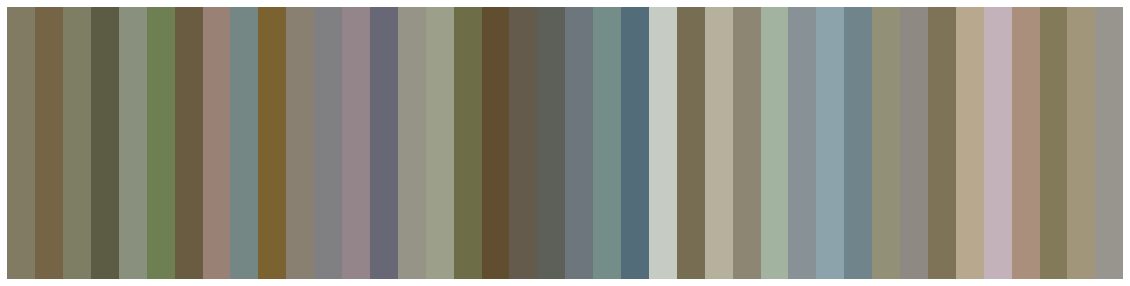

In [165]:
#Palette
scaled_colours = [[color / 255 for color in row] for row in rgb_pal]
fig, ax = plt.subplots(figsize=(20, 5))
title = "Palette"
#creating bar image
cols = len(scaled_colours)
rows = max([1,int(cols/2.5)])

# Create color Array
barFullData = np.tile(scaled_colours, (rows,1)).reshape(rows, cols, 3)
# Create Image from Array
barImg = Image.fromarray(barFullData, 'RGB')


ax.axis(xmin=0, xmax=len(barFullData))
ax.axis('off')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
for index, colour in enumerate(scaled_colours):
    ax.axvspan(index, index + 1, color=colour)
    ax.patch.set_visible(False)

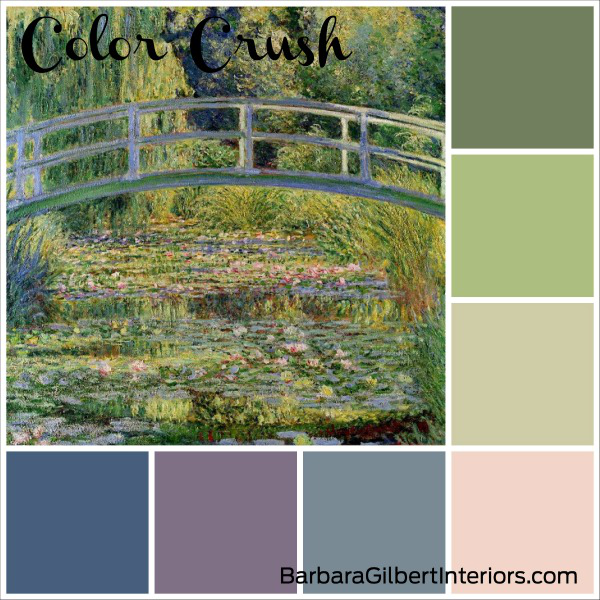

In [166]:
Image.open('/Users/arpit/Desktop/Desk.png')

In [167]:
transform_pal = transforms.Compose([
    transforms.ToTensor()
])

In [168]:
#https://stats.stackexchange.com/questions/178626/how-to-normalize-data-between-1-and-1/178629
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalized data
    """
    return np.array(2*((x - np.min(x)) / (np.max(x) - np.min(x)))-1)

In [172]:
rgb_pal = normalize(rgb_pal)

In [169]:
#Transforming -> Tensor and Normalisation 
rgb_tensor = transform_pal(rgb_pal)

In [170]:
#Palette Tensor Shape
rgb_tensor.shape

torch.Size([1, 100, 3])

In [121]:
#Image Tensor.shape
sing_result.shape

torch.Size([1, 3, 256, 256])

In [171]:
rgb_tensor

tensor([[[ 0.0976,  0.0244, -0.2683],
         [-0.0488, -0.2561, -0.6220],
         [ 0.0610,  0.0610, -0.2561],
         [-0.3537, -0.3659, -0.6585],
         [ 0.1951,  0.2927,  0.0610],
         [-0.1341,  0.0732, -0.4756],
         [-0.1829, -0.3537, -0.6829],
         [ 0.3902,  0.0976, -0.0366],
         [-0.0610,  0.1707,  0.1463],
         [ 0.0122, -0.2683, -0.8902],
         [ 0.1951,  0.0854, -0.0854],
         [ 0.0854,  0.0732,  0.1098],
         [ 0.3171,  0.1463,  0.2073],
         [-0.2073, -0.2195, -0.0488],
         [ 0.3537,  0.3293,  0.1707],
         [ 0.4268,  0.4756,  0.2073],
         [-0.1463, -0.1341, -0.6098],
         [-0.2927, -0.5244, -0.8780],
         [-0.2561, -0.3659, -0.5488],
         [-0.3415, -0.3049, -0.4024],
         [-0.1463, -0.0488,  0.0488],
         [-0.0610,  0.2439,  0.1829],
         [-0.4756, -0.1585,  0.0122],
         [ 0.9390,  1.0000,  0.9024],
         [-0.0244, -0.1463, -0.4756],
         [ 0.7317,  0.6829,  0.4268],
         [ 0

In [219]:
a = sing_result[0][0][1][1].detach()

In [235]:
#Convert to numpy
y=sing_result.detach().numpy()[:,:,:]

In [236]:
y.shape

(1, 3, 256, 256)

In [237]:
y = y[0]

In [238]:
y.shape

(3, 256, 256)

In [239]:
#Extract the single pixel
temp = [y[0][1][1], y[1][1][1], y[2][1][1]]

In [240]:
#first pixel
temp

[-0.885501, -0.2952421, 0.44452396]

In [241]:
rgb_pal[0]

array([ 0.09756098,  0.02439024, -0.26829268])

In [ ]:
#https://stackoverflow.com/questions/9018016/how-to-compare-two-colors-for-similarity-difference

In [264]:
def save(
    tensor: Union[torch.Tensor, List[torch.Tensor]],
    fp: Union[Text, pathlib.Path, BinaryIO],
    format: Optional[str] = None,
    **kwargs
) -> None:
    """Save a given Tensor into an image file.

    Args:
        tensor (Tensor or list): Image to be saved. If given a mini-batch tensor,
            saves the tensor as a grid of images by calling ``make_grid``.
        fp (string or file object): A filename or a file object
        format(Optional):  If omitted, the format to use is determined from the filename extension.
            If a file object was used instead of a filename, this parameter should always be used.
        **kwargs: Other arguments are documented in ``make_grid``.
    """

    grid = make_grid(tensor, **kwargs)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    #im = Image.fromarray(ndarr)
    #im.save(fp, format=format)
    return ndarr

In [268]:
rgb_generated = save(sing_result,'image_{}.png')

In [270]:
rgb_generated.shape

(256, 256, 3)

In [273]:
mp_palette = [tuple(i) for i in mp_palette]

In [274]:
mp_palette

[(99, 123, 129),
 (70, 100, 117),
 (100, 126, 126),
 (67, 91, 92),
 (126, 145, 137),
 (82, 127, 110),
 (65, 92, 106),
 (118, 129, 153),
 (133, 135, 116),
 (48, 99, 122),
 (114, 128, 137),
 (130, 127, 128),
 (138, 133, 147),
 (117, 103, 104),
 (135, 148, 150),
 (138, 160, 156),
 (71, 110, 109),
 (49, 78, 97),
 (76, 91, 100),
 (88, 96, 93),
 (125, 117, 109),
 (136, 141, 116),
 (122, 108, 82),
 (195, 203, 198),
 (82, 109, 119),
 (156, 177, 181),
 (115, 134, 140),
 (160, 180, 162),
 (149, 145, 136),
 (172, 163, 141),
 (139, 132, 111),
 (120, 145, 146),
 (131, 137, 143),
 (87, 115, 126),
 (142, 168, 183),
 (186, 178, 195),
 (125, 143, 171),
 (89, 122, 131),
 (122, 150, 161),
 (142, 149, 152),
 (126, 148, 164),
 (89, 99, 92),
 (171, 168, 174),
 (101, 109, 121),
 (119, 101, 99),
 (120, 112, 112),
 (81, 117, 110),
 (103, 108, 105),
 (132, 132, 138),
 (178, 182, 176),
 (148, 143, 127),
 (148, 145, 143),
 (99, 136, 150),
 (134, 140, 148),
 (136, 136, 139),
 (140, 142, 144),
 (140, 145, 143),
 (1

In [277]:
#First pixel
tuple(rgb_generated[1][1])

(0, 0, 113)

In [283]:
def lum(c):
    def factor(component):
        #component = component / 255;
        if (component <= 0.03928):
            component = component / 12.92;
        else:
            component = math.pow(((component + 0.055) / 1.055), 2.4);

        return component
    components = [factor(ci) for ci in c]

    return (components[0] * 0.2126 + components[1] * 0.7152 + components[2] * 0.0722) + 0.05;

def color_distance(c1, c2):

    l1 = lum(c1)
    l2 = lum(c2)
    higher = max(l1, l2)
    lower = min(l1, l2)

    return (higher - lower) / higher


c1 = rgb_generated[1][1]
c2 = mp_palette[69]
print(color_distance(c1, c2))

0.9601425258048766


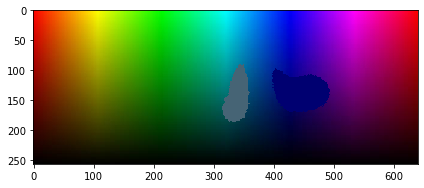

In [285]:
#Checking if rgb is correct or not

rgb = io.imread('https://i.stack.imgur.com/npnrv.png')
lab = rgb2lab(rgb)

c1 = rgb_generated[1][1]
c2 = mp_palette[1]

threshold_green = 15    
threshold_magenta = 20    

green_3d = np.uint8(np.asarray([[c1]]))
magenta_3d = np.uint8(np.asarray([[c2]]))

dE_green = deltaE_cie76(rgb2lab(green_3d), lab)
dE_magenta = deltaE_cie76(rgb2lab(magenta_3d), lab)

rgb[dE_green < threshold_green] = green_3d
rgb[dE_magenta < threshold_magenta] = magenta_3d
io.imshow(rgb)

In [8]:
dataset_name = 'monet2photo'
os.makedirs("images/%s" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [9]:
# Initialize generator and discriminator
input_shape = (3,256,256)
G_AB = GeneratorResNet(input_shape, 9)
G_BA = GeneratorResNet(input_shape, 9)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

In [10]:
#Chaneg epoch here to load saved models
epoch = 199

if epoch != 0:
    # Load pretrained models
    G_AB.load_state_dict(torch.load("saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch),map_location=torch.device('cpu')))
    G_BA.load_state_dict(torch.load("saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch),map_location=torch.device('cpu')))
    D_A.load_state_dict(torch.load("saved_models/%s/D_A_%d.pth" % (dataset_name, epoch),map_location=torch.device('cpu')))
    D_B.load_state_dict(torch.load("saved_models/%s/D_B_%d.pth" % (dataset_name, epoch),map_location=torch.device('cpu')))
else:
    # Initialize weights
    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)

In [11]:
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_epochs = 200
decay_epoch = 100
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs,epoch, decay_epoch).step
)

In [12]:
# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [13]:
# Image transformations
transforms_ = [
    transforms.Resize(int(256 * 1.12), Image.BICUBIC),
    transforms.RandomCrop((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

In [14]:
# Training data loader
dataloader = DataLoader(
    ImageDataset("%s" % dataset_name, transforms_=transforms_, unaligned=True),
    batch_size=1,
    shuffle=True,
)
# Test data loader
val_dataloader = DataLoader(
    ImageDataset("%s" % dataset_name, transforms_=transforms_, unaligned=True, mode="test"),
    batch_size=1,
    shuffle=True,
)

In [15]:
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images/%s/%s.png" % (dataset_name, batches_done), normalize=False)

In [ ]:
# ----------
#  Training
# ----------
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
sample_interval = 200
lambda_cyc = 10
lambda_id = 5
prev_time = time.time()
for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)
         # ------------------
        #  Train Generators
        # ------------------

        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()
        
        print('Loss calculated')
        
         # -----------------------
        #  Train Discriminator A
        # -----------------------
        print('Disc A')
        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------
        print('Disc B')
        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
        print(prev_time)

        # Print log
        print(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )
        # If at sample interval save image
        if batches_done % sample_interval == 0:
            sample_images(batches_done)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    print('Now Saving Results')
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(G_AB.state_dict(), "saved_models/%s/G_AB_%d.pth" % (dataset_name, epoch))
        torch.save(G_BA.state_dict(), "saved_models/%s/G_BA_%d.pth" % (dataset_name, epoch))
        torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (dataset_name, epoch))
        torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (dataset_name, epoch))

In [ ]:
#If running for the firest time unccoment the below lines
#os.mkdir('images_fake')
#os.mkdir('images_fake_paintings')
#os.mkdir('Generated_Paintings')
Tensor = torch.Tensor

for i, batch in enumerate(val_dataloader):
    # Set model input
    #real_A = Variable(batch["A"].type(Tensor))
    #real_B = Variable(batch["B"].type(Tensor))

    # Adversarial ground truths
    #valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
    #fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

    #imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(batch["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(batch["B"].type(Tensor))
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid1 = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    image_grid2 = torch.cat((real_B, fake_A),1)
    #It will store all the four categories in images_fake
    save_image(image_grid1, "images_fake/%s.png" % (i), normalize=False)
    #It will store natural images and generated paintings in images_fake_paintings/ folder
    save_image(image_grid2, "images_fake_paintings/%s.png" % (i), normalize=False)
    #It will only store generated painitngs in Generated_Paintings/ folder
    save_image(fake_A, "Generated_Paintings/%s.png" % (i), normalize=True)

In [ ]:
#For simgle Image
pil_img = Image.open('/Users/arpit/Downloads/IMG_6612.jpg')
print(pil_img.size)  
p = transforms.Compose([transforms.Resize((256,256))])
pil_to_tensor = transforms.ToTensor()(p(pil_img)).unsqueeze_(0)
print(pil_to_tensor.shape) 
fake_A = G_BA(pil_to_tensor)
save_image(fake_A, "Generated_Paintings/unique.png", normalize=True)

In [ ]:
#If running for the firest time unccoment the below lines
os.mkdir('images_fake')
os.mkdir('images_fake_paintings')
os.mkdir('Generated_Paintings')
for i, batch in enumerate(val_dataloader):
    # Set model input
    #real_A = Variable(batch["A"].type(Tensor))
    #real_B = Variable(batch["B"].type(Tensor))

    # Adversarial ground truths
    #valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
    #fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(batch["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(batch["B"].type(Tensor))
    fake_A = G_BA(real_B)
    #Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid1 = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    image_grid2 = torch.cat((real_B, fake_A),1)
    #It will store all the four categories in images_fake
    save_image(image_grid1, "images_fake/%s.png" % (i), normalize=False)
    #It will store natural images and generated paintings in images_fake_paintings/ folder
    save_image(image_grid2, "images_fake_paintings/%s.png" % (i), normalize=False)
    #It will only store generated painitngs in Generated_Paintings/ folder
    save_image(fake_A, "Generated_Paintings/%s.png" % (i), normalize=True)